In [1]:
import cv2
import numpy as np
from scipy.spatial.distance import hamming
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def show_images(imgs, labels):
    if isinstance(imgs, list):
        fig, axs = plt.subplots(nrows=1, ncols=len(imgs), figsize=(8, 8 * len(imgs)))

        for ax, img, label in zip(axs, imgs, labels):
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(label)
            ax.axis('off')
    else:
        plt.imshow(cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB))
        plt.title(labels)
        plt.axis('off')

    plt.show()

In [3]:
def get_random_part(image, part_height, part_width):
    max_x = image.shape[1] - part_width
    max_y = image.shape[0] - part_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + part_height, x: x + part_width]

    return crop

In [4]:
images_paths = [
    "CV-2-Photos/img1.jpg", "CV-2-Photos/img2.jpeg", "CV-2-Photos/img3.jpeg", "CV-2-Photos/img4.jpg",
    "CV-2-Photos/img5.jpg", "CV-2-Photos/HighRes.jpg", "CV-2-Photos/LowRes.jpg", "CV-2-Photos/LowContrast.jpg"
]

imgs = [cv2.imread(path) for path in images_paths]
imgs_ = []
for img in imgs:
    h, w, _ = img.shape

    imgs_.append(get_random_part(img, max(100, int(h * 0.4)), max(100, int(h * 0.4))))

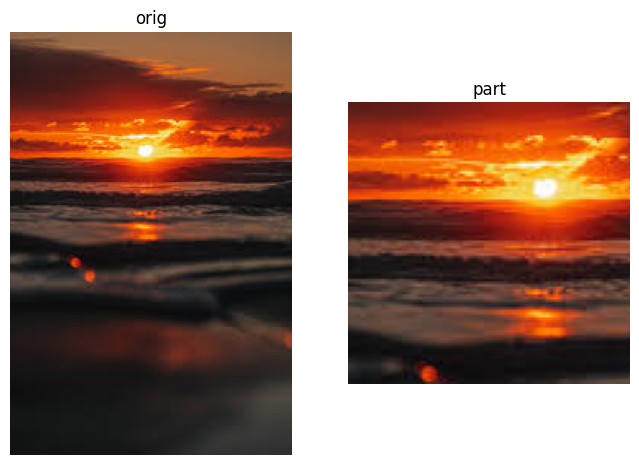

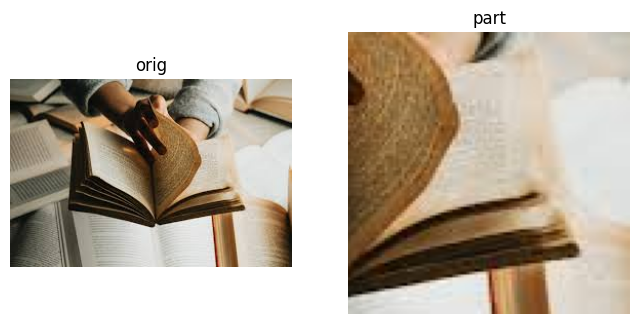

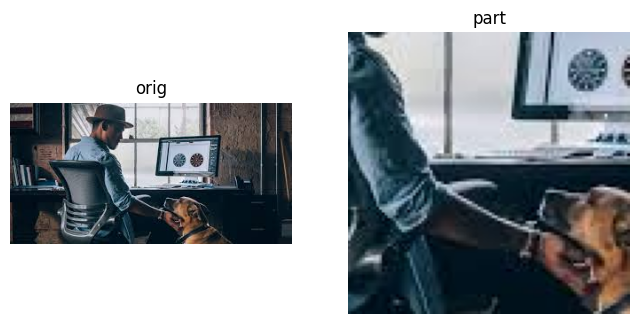

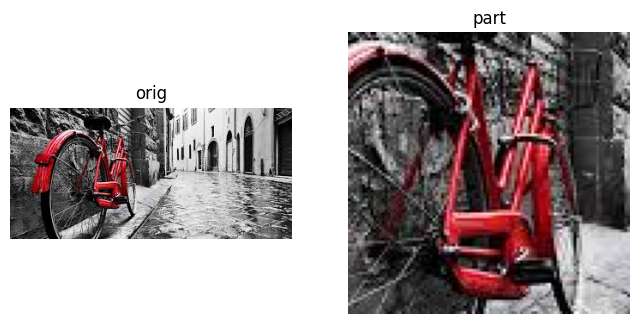

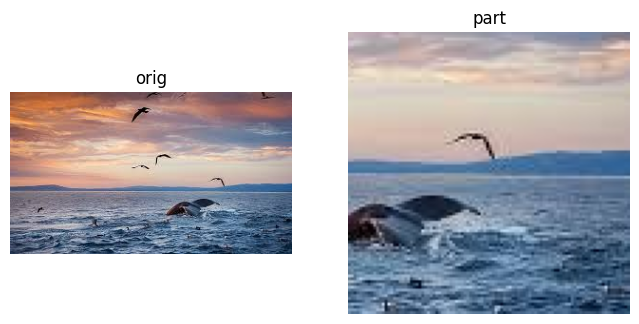

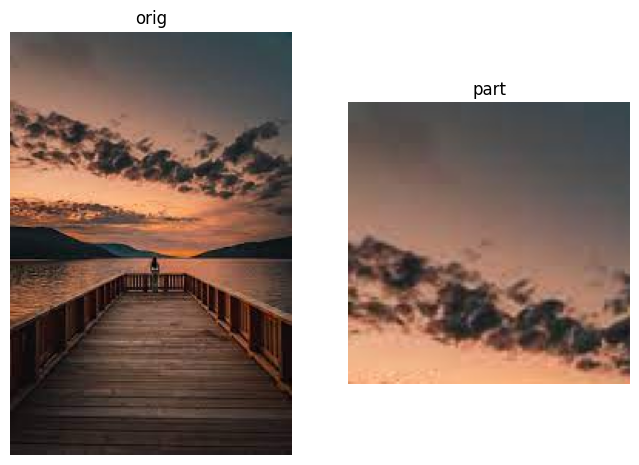

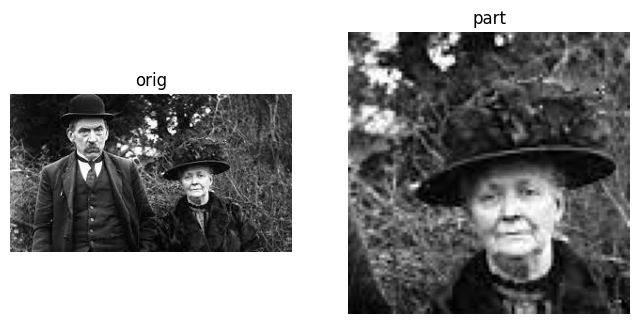

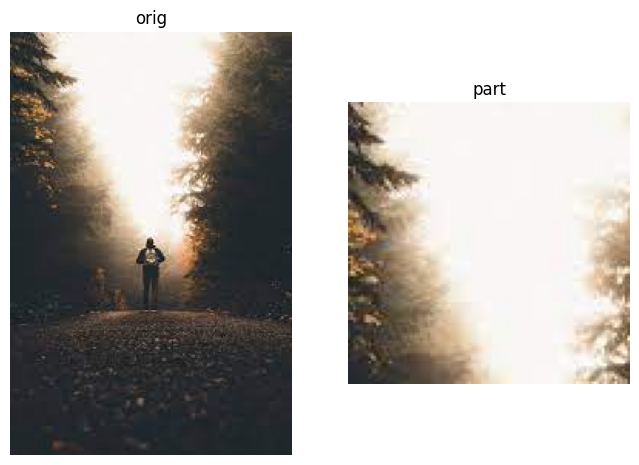

In [5]:
for img, img_ in zip(imgs, imgs_):
    show_images([img, img_], ["orig", "part"])

In [6]:
indexes = np.random.RandomState(123).choice(486, 256, replace=False)

In [7]:
def ldb_match(descriptors_0, descriptors_1):
    matchings = []
    for i1, d1 in enumerate(descriptors_0):
        distances = []
        for i2, d2 in enumerate(descriptors_1):
            distances.append(hamming(d1, d2))

        i2_min = np.argmin(distances)
        matchings.append(cv2.DMatch(_distance=distances[i2_min], _imgIdx=0, _queryIdx=i1, _trainIdx=i2_min))

    return matchings

In [8]:
def get_grid_mean(patch, grid_shape):
    s = patch.shape[0] // grid_shape
    res = np.zeros(grid_shape * grid_shape)

    for row in range(grid_shape):
        for col in range(grid_shape):
            res[row * grid_shape + col] = np.mean(patch[col * s: (col + 1) * s, row * s:(row + 1) * s])

    return res


def ldb_descriptors(img, key_points, patch_size):

    pad = (patch_size - 1) // 2

    padded_img = np.zeros(img.shape + np.array([2 * pad, 2 * pad]), dtype=img.dtype)

    padded_img[pad:-pad, pad:-pad] = img[:, :]

    gradient_x = cv2.Sobel(padded_img, ddepth=cv2.CV_32F, dx=1, dy=0)
    gradient_y = cv2.Sobel(padded_img, ddepth=cv2.CV_32F, dx=0, dy=1)
    gradient_x = cv2.convertScaleAbs(gradient_x)
    gradient_y = cv2.convertScaleAbs(gradient_y)

    #print(f"{len(key_points)=}")

    res = np.zeros([len(key_points), 256 // 8], dtype="uint8")

    for key_num, key_point in tqdm(enumerate(key_points)):
        #  cv2.KeyPoint (angle:float, class_id:int, octave:int, pt:tuple[flat, float], response: float, size: float)
        x, y = key_point.pt
        x, y = int(x), int(y)
        patch = padded_img[x - pad: x + pad + 1, y - pad: y + pad + 1]
        patch_gradient_x = gradient_x[x - pad: x + pad + 1, y - pad: y + pad + 1]
        patch_gradient_y = gradient_y[x - pad: x + pad + 1, y - pad: y + pad + 1]
        #print(f"{patch.shape=}")

        key_point_descriptor = []

        for grid_shape in [2, 3, 4]:
            # grid 2x2, 3x3 and 4x4
            grid_intensity = get_grid_mean(patch, grid_shape)
            grid_gx = get_grid_mean(patch_gradient_x, grid_shape)
            grid_gy = get_grid_mean(patch_gradient_y, grid_shape)

            #print(f"{len(grid_intensity)}")

            for i in range(grid_shape * grid_shape):
                for j in range(i + 1, grid_shape * grid_shape):
                    key_point_descriptor.append(grid_intensity[i] > grid_intensity[j])
                    key_point_descriptor.append(grid_gx[i] > grid_gx[j])
                    key_point_descriptor.append(grid_gy[i] > grid_gy[j])

        assert len(key_point_descriptor) == 486, f"{len(key_point_descriptor)=}"

        key_point_descriptor = np.array(key_point_descriptor)[indexes]
        key_point_descriptor = np.packbits(key_point_descriptor)

        # print(key_point_descriptor)

        res[key_num, :] = key_point_descriptor[:]

    return res

In [9]:
def own_or_created_match(img0, img1, own_matcher, show_n_best_matches=7):
    orb = cv2.ORB_create(nfeatures=2000)
    img_0_gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    key_points_0 = orb.detect(img_0_gray, None)
    img_1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    key_points_1 = orb.detect(img_1_gray, None)

    descriptors_0 = ldb_descriptors(img_0_gray, key_points_0, patch_size=45)
    descriptors_1 = ldb_descriptors(img_1_gray, key_points_1, patch_size=45)

    if len(descriptors_0) == 0 or len(descriptors_1) == 0:
        print(f"{len(descriptors_0)=}, {len(descriptors_1)=}")
        print(f"{img0.shape=}, {img1.shape=}")
        return img1

    if own_matcher:
        matches = ldb_match(descriptors_0, descriptors_1)
    else:
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        matches = bf.match(descriptors_0, descriptors_1)

    matches = sorted(matches, key=lambda x: x.distance)

    thickness = int(min(img_0_gray.shape) * 0.005) + 1

    return cv2.drawMatches(img0, key_points_0, img1, key_points_1, matches[:show_n_best_matches], None,
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=thickness)

308it [00:00, 1231.15it/s]
28it [00:00, 951.61it/s]


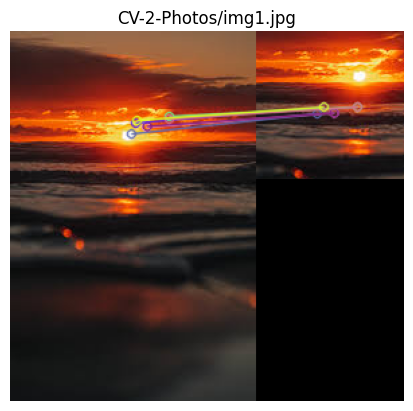

614it [00:00, 1287.04it/s]
15it [00:00, 1346.40it/s]


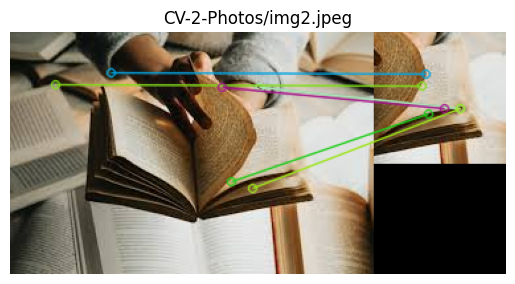

0it [00:00, ?it/s]/home/rost/PycharmProjects/cv-2023/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rost/PycharmProjects/cv-2023/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1049it [00:00, 1233.51it/s]
49it [00:00, 1313.29it/s]


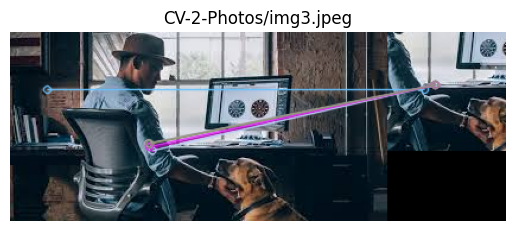

1281it [00:01, 1203.00it/s]
98it [00:00, 1195.00it/s]


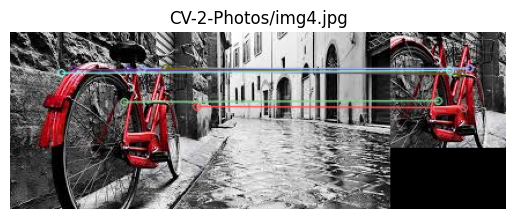

558it [00:00, 1219.93it/s]
36it [00:00, 810.12it/s]


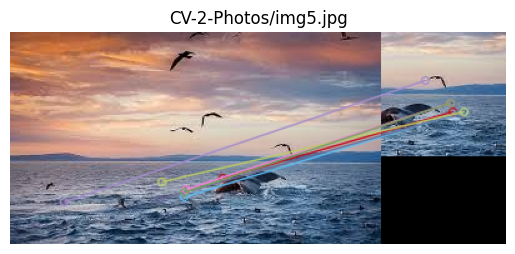

888it [00:00, 1265.51it/s]
44it [00:00, 1352.76it/s]


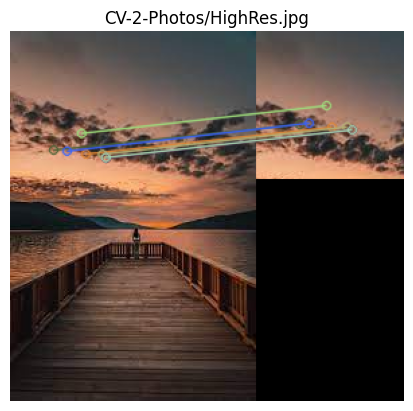

1312it [00:01, 1145.79it/s]
78it [00:00, 1204.90it/s]


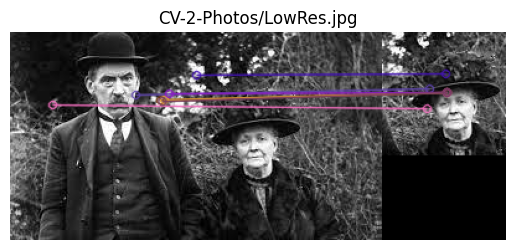

668it [00:00, 1350.62it/s]
2it [00:00, 1033.21it/s]


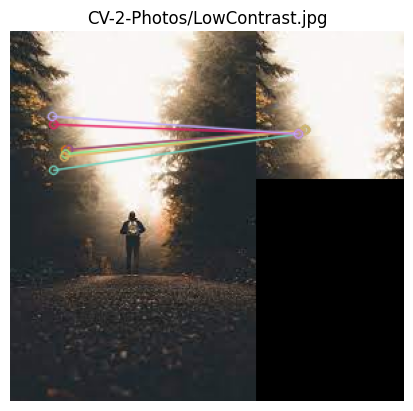

In [10]:
for img, img_, path in zip(imgs, imgs_, images_paths):
    show_images(own_or_created_match(img, img_, own_matcher=False), path)

308it [00:00, 1321.62it/s]
28it [00:00, 1217.50it/s]


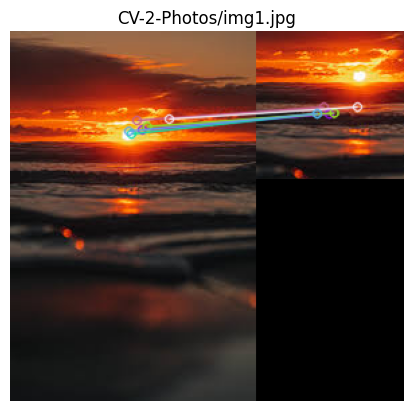

614it [00:00, 1366.58it/s]
15it [00:00, 1420.80it/s]


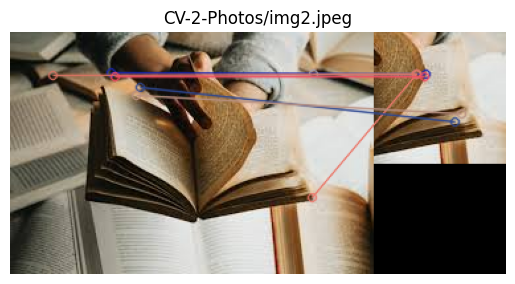

1049it [00:00, 1161.74it/s]
49it [00:00, 1353.90it/s]


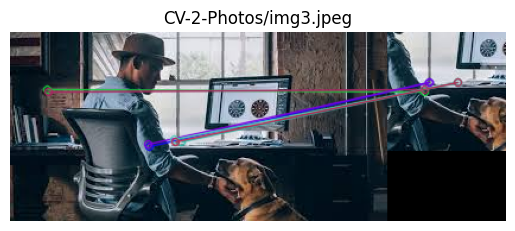

1281it [00:01, 1262.12it/s]
98it [00:00, 1005.72it/s]


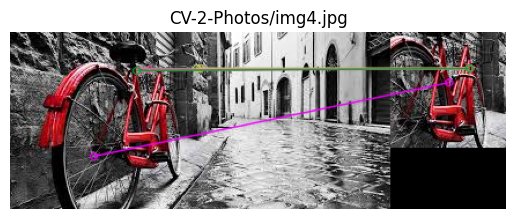

558it [00:00, 963.73it/s] 
36it [00:00, 981.84it/s]


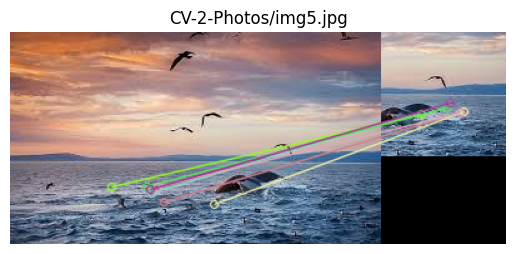

888it [00:00, 1281.14it/s]
44it [00:00, 993.69it/s]


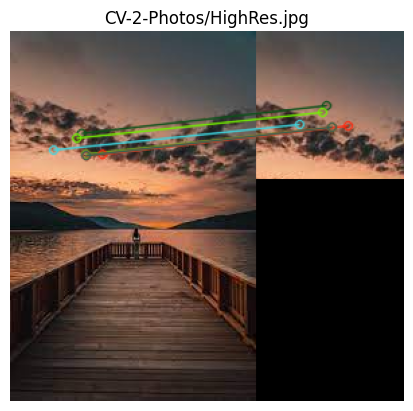

1312it [00:01, 1186.90it/s]
78it [00:00, 1320.98it/s]


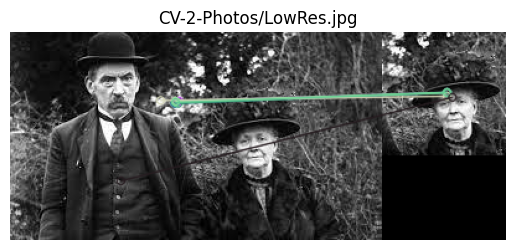

668it [00:00, 1355.46it/s]
2it [00:00, 1047.40it/s]


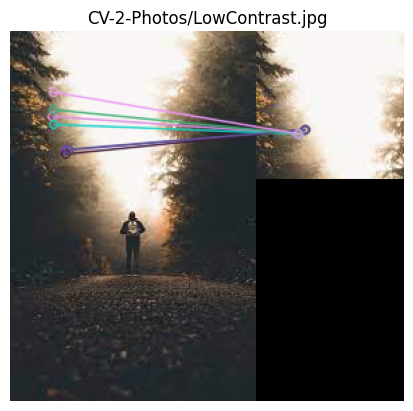

In [11]:
for img, img_, path in zip(imgs, imgs_, images_paths):
    show_images(own_or_created_match(img, img_, own_matcher=True), path)